### CUNY Data 620 - Web Analytics, Summer 2020
**Group Project 1**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

**YouTube Link:** 

### Instructions
1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

### Data Set
* **Source**: [Sociopatterns.org Primary School Dataset](http://www.sociopatterns.org/datasets/primary-school-cumulative-networks/)
* **Format**: The network is stored in a Graph Exchange XML Format (GEXF). 
* **Description**: The information comes from a two-day study of interactions between students and teachers and consists of two weighted networks (one for each day of the study). Nodes in the network represent individuals (students and teachers) and edges represent their face-to-face interactions. For this project, we will focus only on the network of the first day's worth of the interactions. There are 236 nodes and 5,899 connections in the network.
* **Nodes**: Each node has 3 attributes: (1) Classname – school class and grade of the individual, (2) Gender – gender of the individual, (3) Viz – color, size and position in the network.  
* **Edges**: Each node is assigned 2 weights: (1) Duration – total time of the interaction (measured in multiples of 20 seconds) and (2) Count – number of face-to-face interactions between the individuals.


### Motivation
We aim to answer the question: Is there a difference in connectedness (as defined by degree and eigenvector centrality) of males and females? This will tell us if one gender tends to (1) have interactions with a larger number of individuals (degree centrality) and (2) have interactions with individuals that also have a large number of interactions (eigenvector centrality).

Further, we would like to know: is there a difference in interaction duration and frequency between genders? This will tell us if one gender tends to have longer and/or more frequent interactions with their peers.

### Importing Packages

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spy
import numpy as np

### Network Characteristics
We will begin with a preliminary look at the characteristics of the network. First, we'll load in our GEXF file. We can confirm that there are 236 nodes and 5,899 edges. The average degree of the network is ~50, which means that individuals are well connected. We can also see what information is stored about each node and each edge.

In [4]:
G = nx.read_gexf("data/sp_data_school_day_1.gz")
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 236
Number of edges: 5899
Average degree:  49.9915


In [7]:
print('Example information for node 1789: ',G.nodes['1789'])
print('')
print('Example information for the edge (1789,1821): ', G.edges[('1789', '1821')])

Example information for node 1789:  {'classname': '1A', 'gender': 'M', 'viz': {'color': {'r': 0, 'g': 255, 'b': 41}, 'size': 10.0, 'position': {'x': -105.46777, 'y': -61.034737, 'z': 0.0}}, 'label': '1789'}

Example information for the edge (1789,1821):  {'duration': 20, 'count': 1, 'id': '0'}


##### Node Attributes - Classname
Next, we'll take a closer look at the node attributes. The *classname* attribute, which represents the grade and class of the individual, is made up of 10 distinct student classes and 1 teacher class. We can also see the number of teacher nodes in the network. 

In [119]:
classname = nx.get_node_attributes(G, 'classname')
distinctClassname = list(set(classname.values()))
 
# teacher nodes
allTeachers = {key: value for (key, value) in classname.items() if value == 'Teachers'}
  
# distinct classes
print('Distinct classnames: ', distinctClassname)
print('Total number of classnames: ', len(distinctClassname))

# distinct teachers
print('Number of teachers: ', len(allTeachers))  

Distinct classnames:  ['1A', '1B', '3A', 'Teachers', '5A', '4B', '2B', '3B', '4A', '2A', '5B']
Total number of classnames:  11
Number of teachers:  10


With the exception of the "Teacher" classname, which has no color attribute, we can confirm that each classname is associated with a specific color in the network. These colors can be used to better visualize the structure of the network. 

In [121]:
viz = nx.get_node_attributes(G, 'viz')

colors = {}

for c_id, c_info in viz.items():
    for key in c_info:
        if key == 'color': 
            colors[c_id] = c_info[key]

for nm_id, nm_info in classname.items():
    if nm_id in colors:
        colors[nm_id]['nm'] = nm_info

# set of unique colors/classes       
print('Set of unique colors/classes: ')
[dict(s) for s in set(frozenset(d.items()) for d in colors.values())]


Set of unique colors/classes: 


[{'r': 0, 'nm': '2B', 'b': 148, 'g': 168},
 {'b': 250, 'g': 255, 'r': 97, 'nm': '2A'},
 {'r': 255, 'b': 173, 'nm': '5A', 'g': 133},
 {'r': 0, 'b': 194, 'nm': '3B', 'g': 37},
 {'g': 0, 'r': 143, 'b': 43, 'nm': '5B'},
 {'b': 255, 'g': 131, 'nm': '3A', 'r': 117},
 {'b': 0, 'g': 148, 'nm': '1B', 'r': 21},
 {'r': 0, 'g': 255, 'nm': '1A', 'b': 41},
 {'g': 0, 'b': 163, 'r': 155, 'nm': '4B'},
 {'nm': '4A', 'g': 97, 'r': 252, 'b': 255}]

### Network Visualization
Now that we've explored the its characteristics, let's visualize the network.

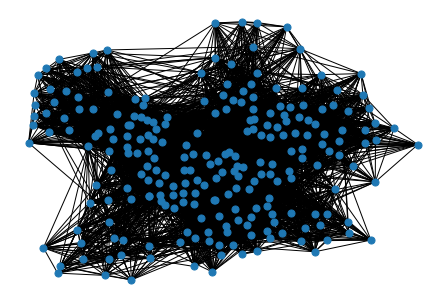

In [126]:
nx.draw_spring(G, with_labels = False, node_size = 50)

Our first look is a bit cluttered. To visualize the data better, we'll alter the colors of the nodes by using an adaptation of the approach taken from the following [stackoverflow question](https://stackoverflow.com/questions/43265020/apply-color-to-specific-node-networkx). First, we'll define a function to access the color attribute of each node (which corresponds to the classname) and convert the colors to hex values.

In [42]:
def convert_to_hex(node) :
    if 'color' in node['viz']:
        red = node['viz']['color']['r']
        green = node['viz']['color']['g']
        blue = node['viz']['color']['b']
    else:
        red = 255
        green = 255
        blue = 255
    return '#%02x%02x%02x' % (red, green, blue)

We'll apply the function to each node. We'll also visualize the gender distribution in the network by assigning the color red to female nodes, blue to male nodes, and white to all others.

In [284]:
# node instead of nodes
colormap = []
gendercmp = []
for n in G:
    colormap.append(convert_to_hex(G.nodes[str(n)]))
    if G.nodes[str(n)]['gender'] == 'F':
        gendercmp.append('red')
    elif G.nodes[str(n)]['gender'] == 'M':
        gendercmp.append('blue')
    else:
        gendercmp.append('white')

##### Visualizing the nodes by classname   
We can start to see the clusters of students in each class. White nodes represent teachers in the network. 

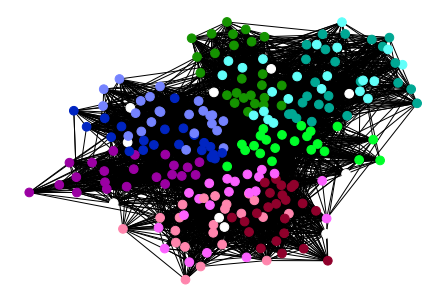

In [285]:
nx.draw_spring(G, with_labels = False, font_weight='bold', node_size = 75, node_color = colormap)

##### Visualizing the nodes by gender
We can also take a look at the distribution by gender. We can see one small cluster of all-female connections, but for the most part, connections are gender-agnostic.

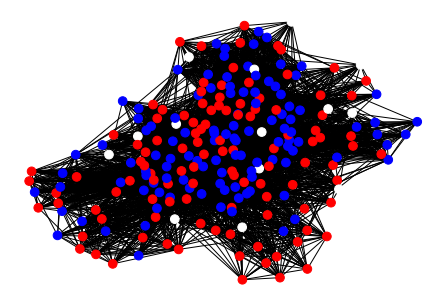

In [286]:
nx.draw_spring(G, with_labels = False, font_weight='bold', node_size = 75, node_color = gendercmp)

### Calculating Centrality Measures

##### Subsetting the data by Gender and evaluating relative centrality metrics
Now that we've done an initial exploration of the network, we can define the degree and eigenvector centrality attributes for each node. Degree centrality will tell us how many connections a node has. Eigenvector centrality will tell us the extent to which a node is connected to other well connected nodes.

These centrality metrics will give us an idea of how important a particular node is based on its degree. In our network, the degree will represent the communications that a student has with other individuals in the network.  

In order to compare centrality metrics across our categorical feature (gender), we'll store these values in separate lists for each gender.

In [219]:
Eigen_cent = nx.eigenvector_centrality(G)
f_d_cent = []
m_d_cent = []
f_e_cent = []
m_e_cent = []
for n in G.nodes:
    G.nodes[str(n)]['cent'] = G.degree[str(n)]#/len(G)
    G.nodes[str(n)]['Eigen_c'] = Eigen_cent[str(n)]
    if G.nodes[str(n)]['gender'] == 'F':
        f_d_cent.append(G.degree[str(n)])#/len(G))
        f_e_cent.append(Eigen_cent[str(n)])
    elif G.nodes[str(n)]['gender'] == 'M':
        m_d_cent.append(G.degree[str(n)])#/len(G))
        m_e_cent.append(Eigen_cent[str(n)])

A first glance at the means of the degree centrality shows a lower average for females than males, and we can confirm the statistical significance with a t-test. 

In [147]:
print('Average female degree centrality: ',np.mean(f_d_cent))
print('Average male degree centrality: ',np.mean(m_d_cent))
print('P-value: ',spy.stats.ttest_ind(f_d_cent,m_d_cent)[1])

Average female degree centrality:  46.64545454545455
Average male degree centrality:  54.50892857142857
P-value:  0.001978790853996787


Based on the results of the t-test (p-value < 0.05) we can conclude that the average degree centrality of the female population is statistically significantly lower than that of the male population of the school. This suggests that on average, female individuals engaged in interactions with fewer individuals.  
  
We see similar results from the comparison of Eigenvector centrality measures between genders:

In [148]:
print('Average female eigenvector centrality: ',np.mean(f_e_cent))
print('Average male eigenvector centrality: ',np.mean(m_e_cent))
print('P-value: ',spy.stats.ttest_ind(f_e_cent,m_e_cent)[1])

Average female eigenvector centrality:  0.0547639891386447
Average male eigenvector centrality:  0.06555186687620164
P-value:  0.0028618838765044558


Once again, the t-test results (p-value < 0.05) indicate that there a statistically significant difference between the female and male students. This means that the males tend to be connected to other highly connected individuals. 

### Further Analysis  - Weight Analytics

Our analysis above shows that the males in our network tend to interact with more people than females, but it doesn't tell us anything about the ***strength*** or ***frequency*** of the communications. Lucky for us, this information available in the form of edge weights -- each edge contains a *count* of interactions and a *duration* of interactions. We'll use these weights to get a better idea of the types of interactions each gender is having.  

##### Gender-specific subgraphs
First, we'll split the network into male and female sub-graphs. Then, we'll identify the frequency and duration of interactions.

In [340]:
# split females and males
female_nodes = [n for n,v in G.nodes(data = True) if v['gender'] == 'F']
male_nodes = [n for n,v in G.nodes(data = True) if v['gender'] == 'M']

# counts and durations for entire network
all_edges, all_count = zip(*nx.get_edge_attributes(G,'count').items())
_, all_dur = zip(*nx.get_edge_attributes(G,'duration').items())

# female subgraph
F = G.subgraph(female_nodes)
f_edges, f_count = zip(*nx.get_edge_attributes(F,'count').items())
_, f_dur = zip(*nx.get_edge_attributes(F,'duration').items())

# male subgraph
M = G.subgraph(male_nodes)
m_edges, m_count = zip(*nx.get_edge_attributes(M,'count').items())
_, m_dur = zip(*nx.get_edge_attributes(M,'duration').items())

Comparing the average female to male counts shows that females tend to interact with their peers more frequently than males.

In [152]:
print('Average female interaction count: ',np.mean(f_count))
print('Average male interaction count: ', np.mean(m_count))
print('P-value: ',spy.stats.ttest_ind(f_count,m_count)[1])

Average female interaction count:  7.632687447346251
Average male interaction count:  6.70245950809838
P-value:  0.040773541356467234


Similarly, comparing the average female to male interaction duration shows that females tend to speak with their peers for a lot longer than males do.

In [153]:
print('Average female interaction duration:',np.mean(f_dur))
print('Average male interaction duration:',np.mean(m_dur))
print('P-value:',spy.stats.ttest_ind(f_dur,m_dur)[1])

Average female interaction duration: 286.1668070766639
Average male interaction duration: 209.03419316136774
P-value: 0.00019564935793008956


So although we've shown that males tend to have interactions with a higher number of individuals, females tend to have longer and more frequent conversations!

### Categorical Subgraph Visualization
Finally, we'll visualize the differences we've just observed between males and females with respect to: centrality, frequency of interactions, and duration of interactions.

##### Degree Centrality
In order to view the differences in degree centrality between males and females, we will:

* Color the nodes based on the degree centrality. Darker colored nodes represent individuals with a higher degree centrality.
* Color the node edges based on gender. Red is female and blue is male. 


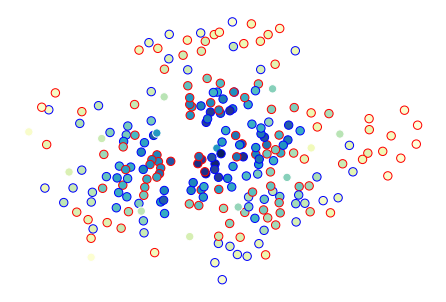

In [308]:
all_nodes, all_cent = zip(*nx.get_node_attributes(G,'cent').items())

pos1 = nx.spring_layout(G)
nx.draw(G, pos1, node_size = 70, node_color = all_cent, cmap = plt.cm.YlGnBu, edgecolors = gendercmp, width = 0)

From this visualization, we can see more yellow female nodes (lower degree centrality) and more blue male nodes (higher degree centrality). This is what we expected based on our degree centrality analysis.

##### Duration of Interactions
In order to view the differences in interaction durations between males and females, we will:

* Color the edge weights according to duration of interaction. Lighter colors represent shorter conversations.
* Color the nodes based on gender.

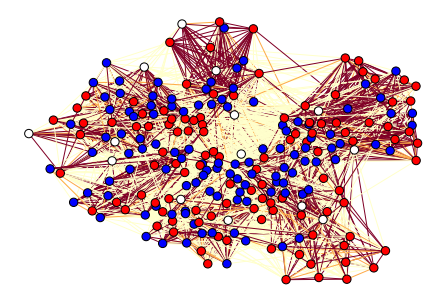

In [337]:
pos = nx.spring_layout(G)
nx.draw(G, pos,node_size = 70, node_color = gendercmp, edgecolors = 'black', edgelist = all_edges, edge_color=all_dur, 
        edge_cmap=plt.cm.YlOrRd, edge_vmin = 50, edge_vmax = 75)

After many trials and errors, this was the final graphic. It's not as clear from this graphic that females tend to have longer conversations.

In [376]:
f_dur_ls = []
for idx,val in enumerate(f_edges):
    f_dur_ls.append([val[0],f_dur[idx]])
    f_dur_ls.append([val[1],f_dur[idx]])

f_dur_df = pd.DataFrame(f_dur_ls, columns = ['node','dur'])
f_total_dur = df.groupby(['node']).sum()


m_dur_ls = []
for idx,val in enumerate(f_edges):
    m_dur_ls.append([val[0],f_dur[idx]])
    m_dur_ls.append([val[1],f_dur[idx]])

m_dur_df = pd.DataFrame(m_dur_ls, columns = ['node','dur'])
m_total_dur = df.groupby(['node']).sum()

### Conclusions & Discussion